## Instability of Parameter Estimates

### Parameters
A parameter is a quantity that helps to describe a data set or a distribution. The mean of a normal distribution is a parameter. 

When we calculate the mean of a date set we are estimating the mean. We have estimated the mean as best as we can from the data we have.

### Instability of estimates

Whenever we consider a set of observations, our calculation of a parameter can only be an estimate. We can quantify the uncertainty in our estimate by looking at how the parameter changes as we look at different subsets of the data. Standard deviation describes how different the mean of a set is from the mean of each observation, that is from each observation itself.

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt

sns.set_theme()

#### Mean and standard deviation

Samples from a normal distribution. The mean of this distribution is 0 and the standard deviation 1. But if we measure the parameters from our observations, we will get only approx 0 and 1.

-0.26951611032632805
0.027109073490359778
-0.020616059111720507
-0.038643973513210604


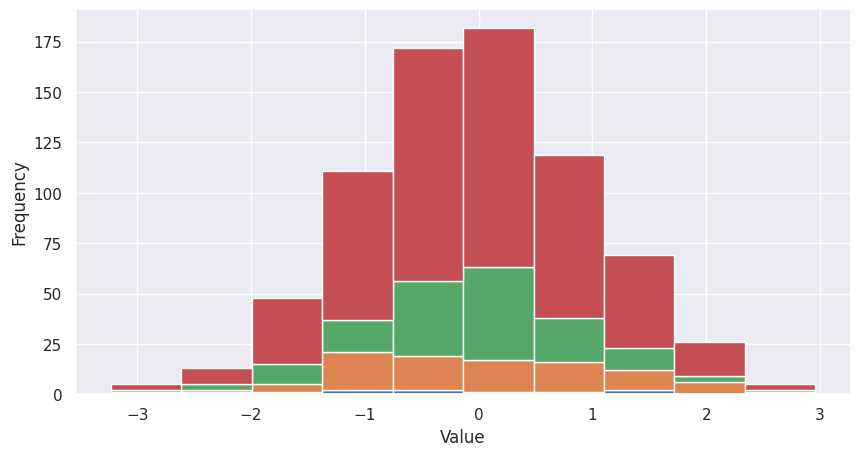

In [59]:
# Set a seed so we can play with the data without generating new random numbers every time
np.random.seed(123)

normal = np.random.randn(500)
print(np.mean(normal[:10]))
print(np.mean(normal[:100]))
print(np.mean(normal[:250]))
print(np.mean(normal))

# Plot a stacked histogram of the data
plt.figure(figsize=[10, 5])
plt.hist([normal[:10], normal[10:100], normal[100:250], normal], histtype='bar', stacked=True);
plt.ylabel('Frequency')
plt.xlabel('Value');

In [60]:
print(np.std(normal[:10]))
print(np.std(normal[:100]))
print(np.std(normal[:250]))
print(np.std(normal))

1.236304801499023
1.128240470477961
1.0174604368340197
1.0032028561568238


Notice that, although the probability of getting closer to 0 and 1 for the mean and standard deviation, respectively, increases with the number of samples, we do not always get better estimates by taking more data points. With time series data, we care about contiguous subsets of the data. The moving average assigns the mean of the previous `n` data points to each point in time.

#### Non-Normal Underlying Distribution

If the underlying data is not normal, a mean will be very deceptive. Because of this it's important to test for normality.

mean: 0.009847581282146528
std: 5.060708740105227


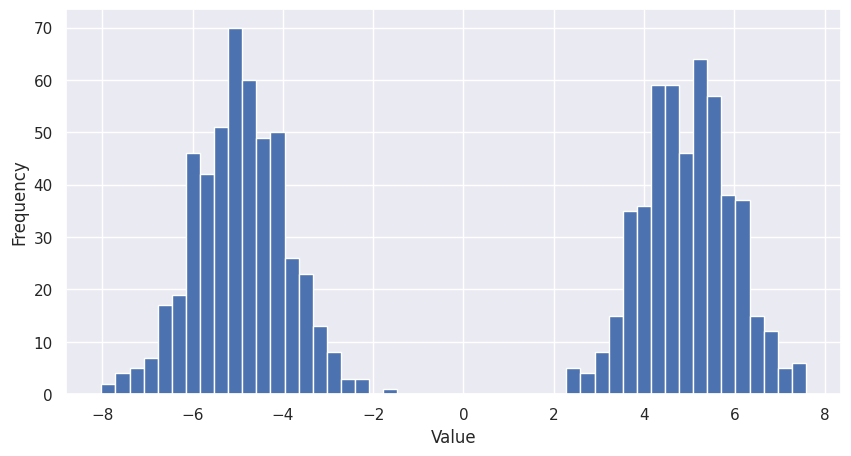

In [61]:
# Generate data from a bi-modal distribution
def bimodal(n):
    X = np.zeros((n))
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] = np.random.normal(5, 1)
    return X

X = bimodal(1000)

plt.figure(figsize=[10, 5])
plt.hist(X, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value')
print('mean:', np.mean(X))
print('std:', np.std(X))

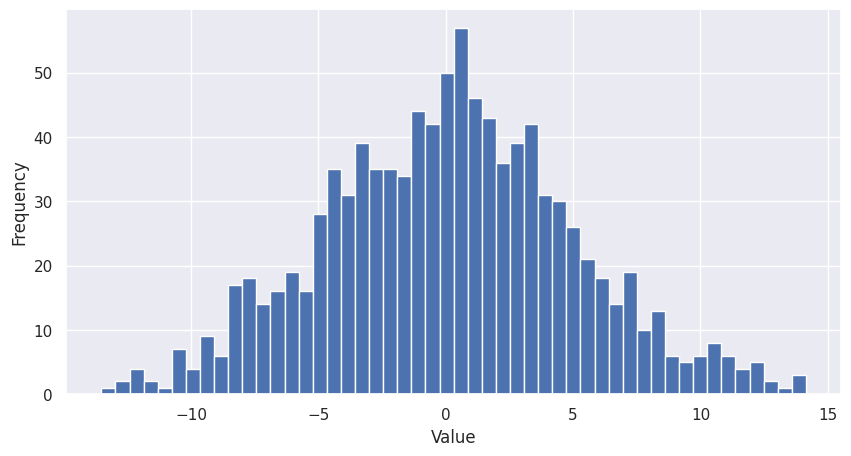

In [62]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.figure(figsize=[10, 5])
plt.hist(N, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value');

Test the data using the Jarque-Bera test to see if it's normal. A significant p-value indicates non-normality.



In [63]:
from statsmodels.stats.stattools import jarque_bera

jarque_bera(X)

(142.12550136207705,
 1.3735343038981241e-31,
 -0.007644415681800414,
 1.1531707484649847)

The pvalue is < 0.05 and we can say X is not normal. This save from making horrible predictions.

#### Sharpe Ratio

Sharpe ratio measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return such as Treasury bills.

$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}}$

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_66622/3233330543.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]]) # Label x-axis with dates


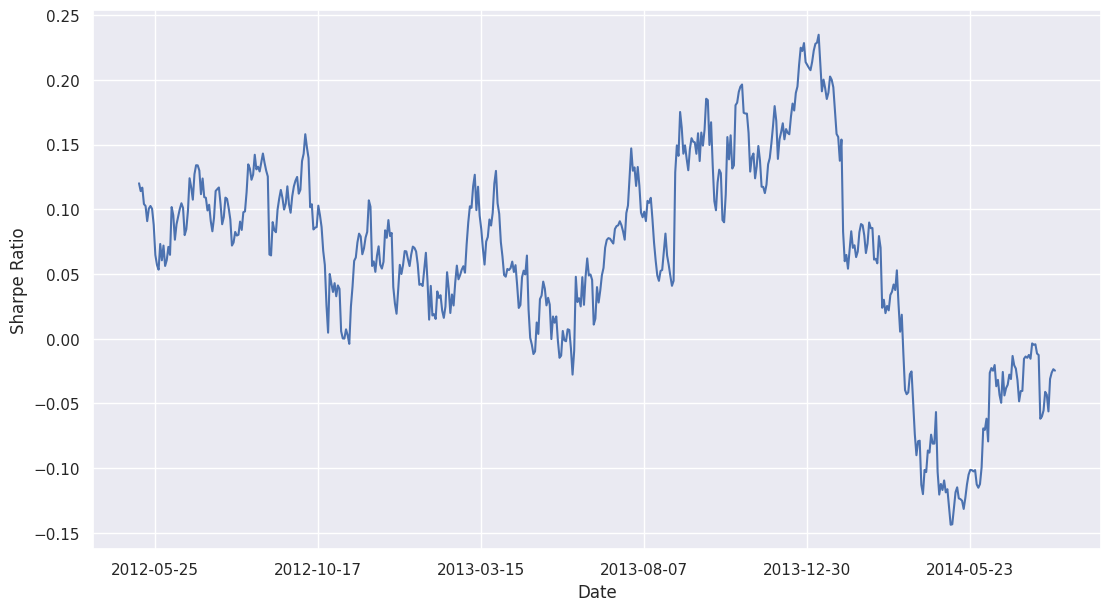

In [64]:
def sharpe_ratio(asset_ret, riskfree_ret):
    return np.mean(asset_ret - riskfree_ret) / np.std(asset_ret - riskfree_ret)

start = '2012-01-01'
end = '2015-01-01'
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = yf.download('BIL', start=start, end=end)['Adj Close'].pct_change()[1:]
pricing = yf.download('AMZN', start=start, end=end)['Adj Close']
returns = pricing.pct_change()[1:]

# Compute the running sharpe ratio
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]

_, ax1 = plt.subplots(figsize=[13, 7])
ax1.plot(range(90, len(returns)-100), running_sharpe[:-100]);
ticks = ax1.get_xticks()
ax1.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio');

Mean of running Sharpe ratio: 0.06406521915507775
std of running Sharpe ratio: 0.07774931524783606


/tmp/ipykernel_66622/1571657585.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]])


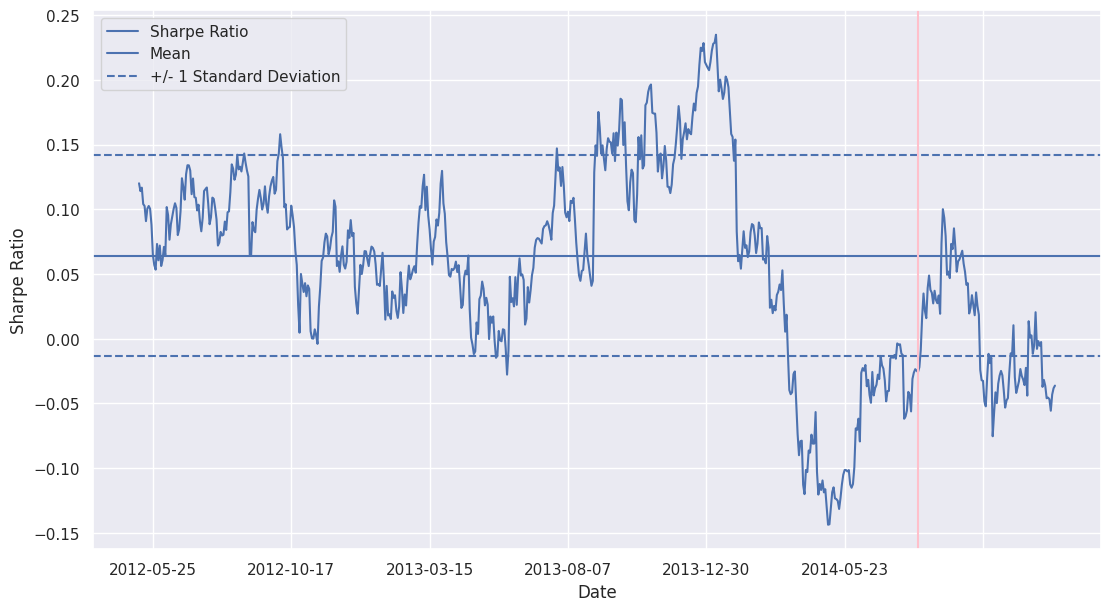

In [65]:
# Compute the mean and std of the running Sharpe ratios up to 100 days before the end.
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

_, ax2 = plt.subplots(figsize=[13, 7])
ax2.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]])
ax2.plot(range(90, len(returns)), running_sharpe)

# Plot its mean and the +/- 1 standard deviation lines
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# Indicate where we computed the mean and std
ax2.axvline(len(returns) - 100, color='pink');
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

print("Mean of running Sharpe ratio:", mean_rs)
print("std of running Sharpe ratio:", std_rs)

#### Moving Average

[*********************100%%**********************]  1 of 1 completed


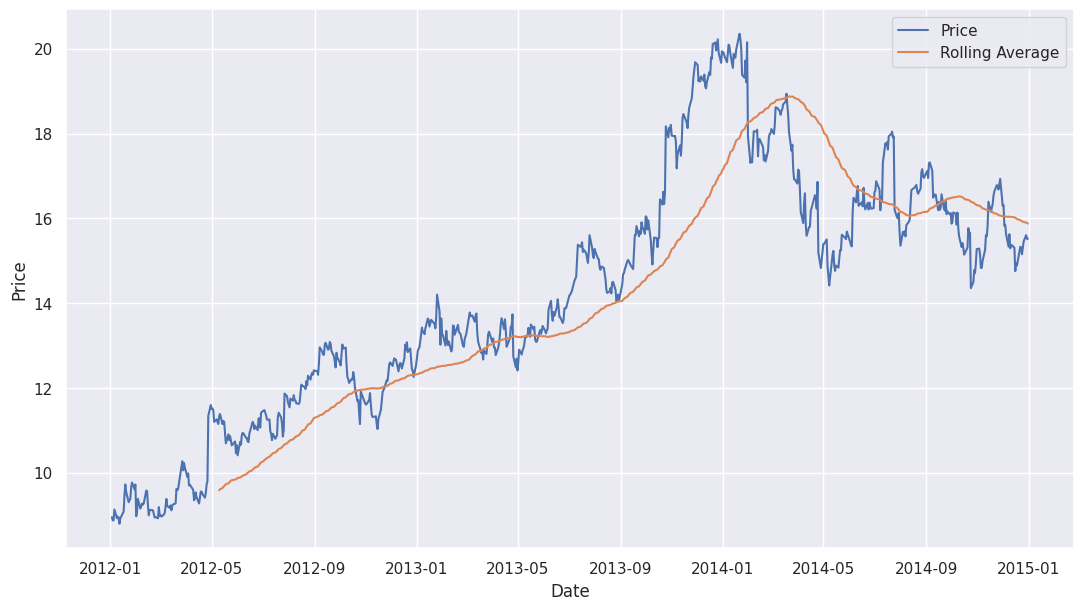

In [66]:
# 90-day moving average
start = '2012-01-01'
end = '2015-01-01'
pricing = yf.download('AMZN', start=start, end=end)['Adj Close']

# Rolling mean for each day
mu = pricing.rolling(window=90).mean()

# Plot
_, ax1 = plt.subplots(figsize=[13, 7])
ax1.plot(pricing)
plt.ylabel('Price')
plt.xlabel('Date')

ax1.plot(mu);
plt.legend(['Price', 'Rolling Average']);

In [67]:
print("Mean of rolling mean:", np.mean(mu))
print("std of rolling mean:", np.std(mu))

Mean of rolling mean: 14.419316972447318
std of rolling mean: 2.5567575075803686


Mean of rolling std: 0.8701913782700503
std of rolling std: 0.3772346255500084


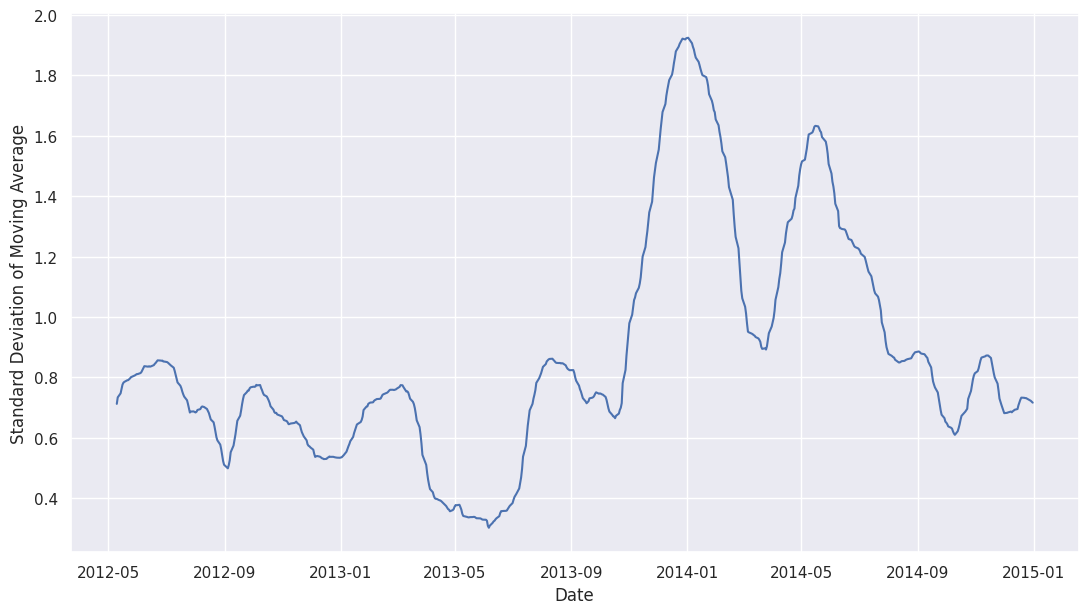

In [68]:
# Rolling standard deviation
std = pricing.rolling(window=90).std()

# Plot
_, ax2 = plt.subplots(figsize=[13, 7])
ax2.plot(std)
plt.ylabel('Standard Deviation of Moving Average')
plt.xlabel('Date')

print("Mean of rolling std:", np.mean(std))
print("std of rolling std:", np.std(std))

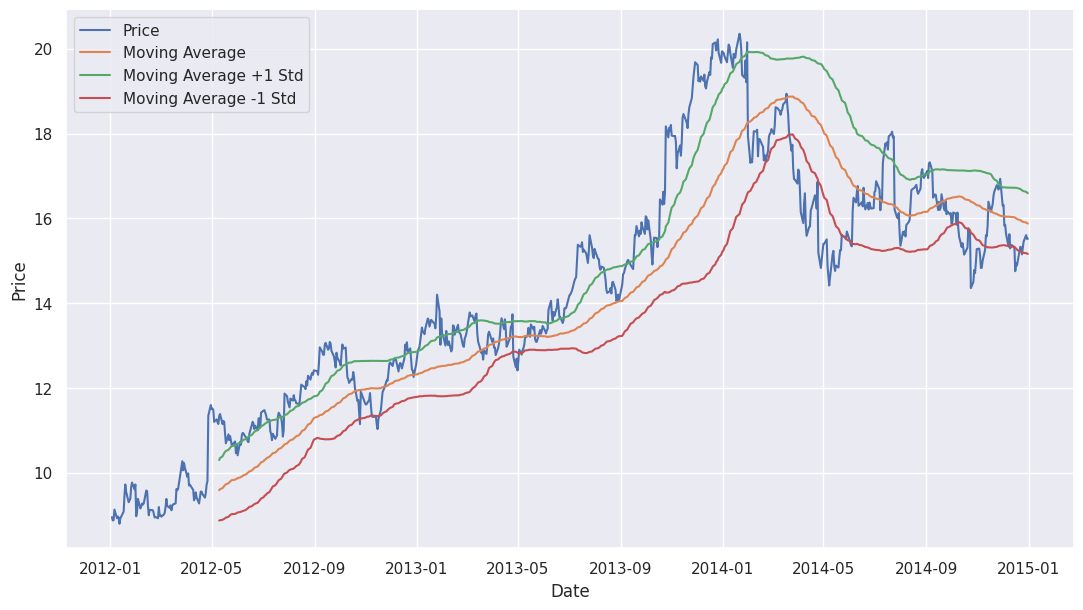

In [69]:
# Plot data along with Bollinger bands
_, ax3 = plt.subplots(figsize=[13, 7])
ax3.plot(pricing)

# Plot BB
ax3.plot(mu)
ax3.plot(mu + std)
ax3.plot(mu - std);
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Price', 'Moving Average', 'Moving Average +1 Std', 'Moving Average -1 Std'])

### Exercises

In [70]:
# Set a seed so we can play with data without generating new numbers every time
np.random.seed(321)

In [71]:
POPULATION_MU = 100
POPULATION_SIGMA = 25
sample_sizes = [5, 25, 100, 500]

for i in range(len(sample_sizes)):
    normal_dist = np.random.normal(loc=POPULATION_MU, scale=POPULATION_SIGMA, size=sample_sizes[i])
    row = 'Mean',(i+1),':', np.mean(normal_dist),'Std',(i+1),':',np.std(normal_dist)
    print(("{} {}{} {:<10f}    {} {}{} {}").format(*row))


Mean 1: 99.089982     Std 1: 24.464117165854354
Mean 2: 94.706474     Std 2: 20.124631005086126
Mean 3: 100.107503    Std 3: 24.674888901478063
Mean 4: 100.661661    Std 4: 24.664960530938306


In [72]:
X = [ 31.,   6.,  21.,  32.,  41.,   4.,  48.,  38.,  43.,  36.,  50., 20.,  46.,  33.,   8.,  27.,  17.,  44.,  16.,  39.,   3.,  37.,
        35.,  13.,  49.,   2.,  18.,  42.,  22.,  25.,  15.,  24.,  11., 19.,   5.,  40.,  12.,  10.,   1.,  45.,  26.,  29.,   7.,  30.,
        14.,  23.,  28.,   0.,  34.,   9.,  47.]
Y = [ 15.,  41.,  33.,  29.,   3.,  28.,  28.,   8.,  15.,  22.,  39., 38.,  22.,  10.,  39.,  40.,  24.,  15.,  21.,  25.,  17.,  33.,
        40.,  32.,  42.,   5.,  39.,   8.,  15.,  25.,  37.,  33.,  14., 25.,   1.,  31.,  45.,   5.,   6.,  19.,  13.,  39.,  18.,  49.,
        13.,  38.,   8.,  25.,  32.,  40.,  17.]
Z = [ 38.,  23.,  16.,  35.,  48.,  18.,  48.,  38.,  24.,  27.,  24., 35.,  37.,  28.,  11.,  12.,  31.,  -1.,   9.,  19.,  20.,   0.,
        23.,  33.,  34.,  24.,  14.,  28.,  12.,  25.,  53.,  19.,  42., 21.,  15.,  36.,  47.,  20.,  26.,  41.,  33.,  50.,  26.,  22.,
        -1.,  35.,  10.,  25.,  23.,  24.,   6.]

print("Mean X: %.2f" % np.mean(X))
print("Mean Y: %.2f" % np.mean(Y))
print("Mean Z: %.2f" % np.mean(Z))

Mean X: 25.00
Mean Y: 24.69
Mean Z: 25.61


In [73]:
print("pvalue for X: %.10f" % jarque_bera(X)[1])
print("pvalue for Y: %.10f" % jarque_bera(Y)[1])
print("pvalue for Z: %.10f" % jarque_bera(Z)[1])

pvalue for X: 0.2160263795
pvalue for Y: 0.2502813122
pvalue for Z: 0.8669070018


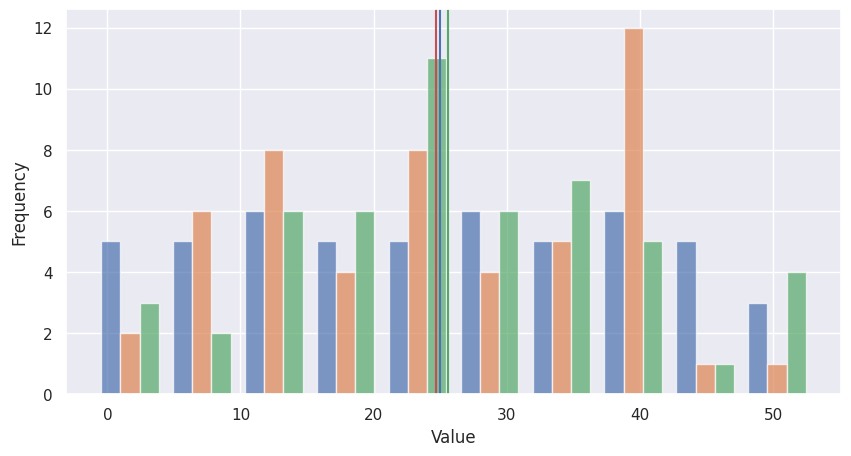

In [74]:
# Create an histogram of the sample distributions X, Y, and Z.
plt.figure(figsize=[10, 5])
plt.hist([X, Y, Z], histtype='bar', stacked=False, alpha=0.7);
plt.axvline(np.mean(X));
plt.axvline(np.mean(Y), c='r');
plt.axvline(np.mean(Z), c='g');
plt.ylabel('Frequency')
plt.xlabel('Value');

#### Sharpe Ratio window adjustment

Find the mean and std of the running sharpe ratio for THO, testing for multiple window lengths.

In [75]:
start = '2010-01-01'
end = '2015-01-01'

treasury_ret = yf.download('BIL', start=start, end=end)['Adj Close'].pct_change()[1:]
pricing = yf.download('THO', start=start, end=end)['Adj Close']
returns = pricing.pct_change()[1:]

for window in [50, 150, 300]:
    running_sr = [sharpe_ratio(returns[i-window+10:i], treasury_ret[i-window+10:i]) for i in range(window-10, len(returns))]
    mean_rs = np.mean(running_sr[:-200])
    std_rs = np.std(running_sr[:-200])

    row = 'Sharpe Mean',(window),':', mean_rs,'Std', window,':',std_rs
    print(("{} {:>3}{} {:<11f}    {:>5} {:>3}{} {}").format(*row))
    
print("As we increase the length of the window, the variability of the running sharpe ratio decreases.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Sharpe Mean  50: 0.043438         Std  50: 0.15295935771398503
Sharpe Mean 150: 0.046995         Std 150: 0.07161611428819487
Sharpe Mean 300: 0.044727         Std 300: 0.043942522686921864
As we increase the length of the window, the variability of the running sharpe ratio decreases.


/tmp/ipykernel_66622/86545953.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]])
/tmp/ipykernel_66622/86545953.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]])
/tmp/ipykernel_66622/86545953.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]])


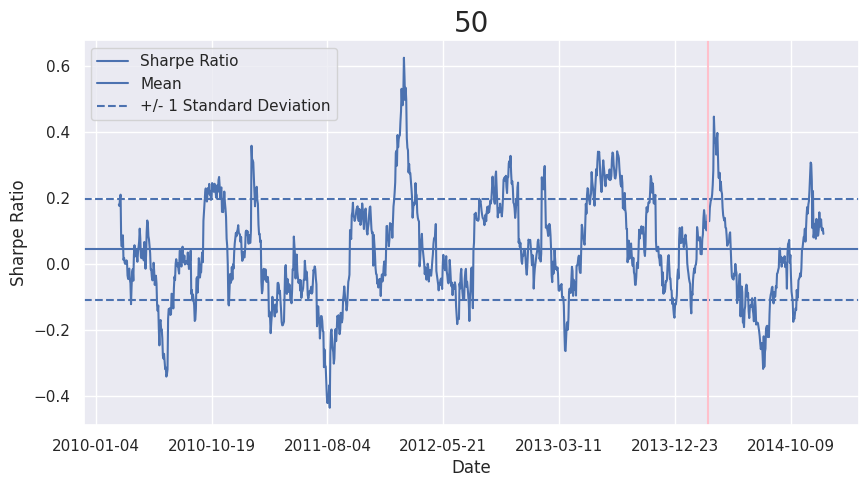

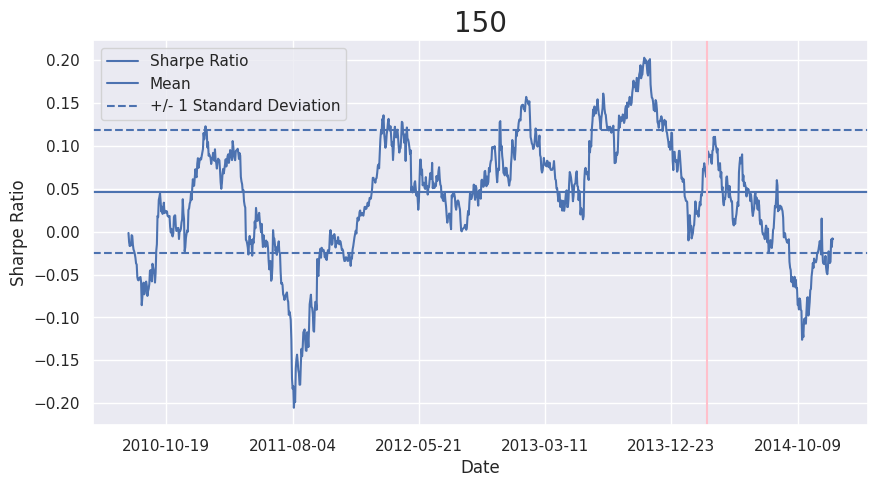

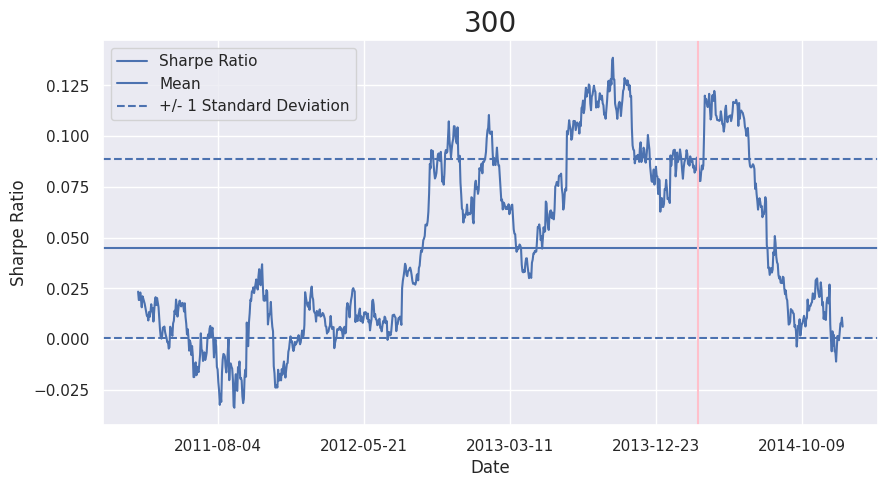

In [76]:
for window in [50, 150, 300]:
    running_sr = [sharpe_ratio(returns[i-window+10:i], treasury_ret[i-window+10:i]) for i in range(window-10, len(returns))]
    mean_rs = np.mean(running_sr[:-200])
    std_rs = np.std(running_sr[:-200])

    _, ax2 = plt.subplots(figsize=[10, 5])

    ax2.plot(range(window-10, len(returns)), running_sr)
    ticks = ax2.get_xticks()

    ax2.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-1]])

    ax2.axhline(mean_rs)
    ax2.axhline(mean_rs + std_rs, linestyle='--')
    ax2.axhline(mean_rs - std_rs, linestyle='--')

    ax2.axvline(len(returns) - 200, color='pink');
    plt.title(window, fontsize = 20)
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

Find the mean and standard deviation of Boston weekly average temperature data for the year of 2015 stored in b15_df.

In [77]:
b15_df = pd.DataFrame([ 29.,  22.,  19.,  17.,  19.,  19.,  15.,  16.,  18.,  25.,  21.,
        25.,  29.,  27.,  36.,  38.,  40.,  44.,  49.,  50.,  58.,  61.,
        67.,  69.,  74.,  72.,  76.,  81.,  81.,  80.,  83.,  82.,  80.,
        79.,  79.,  80.,  74.,  72.,  68.,  68.,  65.,  61.,  57.,  50.,
        46.,  42.,  41.,  35.,  30.,  27.,  28.,  28.],
        columns = ['Weekly Avg Temp'],
        index = pd.date_range('1/1/2015', periods=52, freq='W'))

b15_mean = np.mean(b15_df['Weekly Avg Temp'])
b15_std = np.std(b15_df['Weekly Avg Temp'])

print(f"The mean of Boston weekly average temperature in 2015 is {b15_mean}")
print(f"The standard deviation of Boston weekly average temperature in 2015 is {b15_std}")

The mean of Boston weekly average temperature in 2015 is 49.07692307692308
The standard deviation of Boston weekly average temperature in 2015 is 22.983979498978574


In [78]:
p15_df = pd.DataFrame([ 49.,  53.,  51.,  47.,  50.,  46.,  49.,  51.,  49.,  45.,  52.,
        54.,  54.,  55.,  55.,  57.,  56.,  56.,  57.,  63.,  63.,  65.,
        65.,  69.,  67.,  70.,  67.,  67.,  68.,  68.,  70.,  72.,  72.,
        70.,  72.,  70.,  66.,  66.,  68.,  68.,  65.,  66.,  62.,  61.,
        63.,  57.,  55.,  55.,  55.,  55.,  55.,  48.],
        columns = ['Weekly Avg Temp'],
        index = pd.date_range('1/1/2015', periods=52, freq='W'))

p15_mean = np.mean(p15_df['Weekly Avg Temp'])
p15_std = np.std(p15_df['Weekly Avg Temp'])

print(f"The mean of Palo Alto weekly average temperature in 2015 is {p15_mean}")
print(f"The standard deviation of Palo Alto weekly average temperature in 2015 is {p15_std}")

The mean of Palo Alto weekly average temperature in 2015 is 59.78846153846154
The standard deviation of Palo Alto weekly average temperature in 2015 is 7.9743254801835945


Predicting 2016 Temperatures

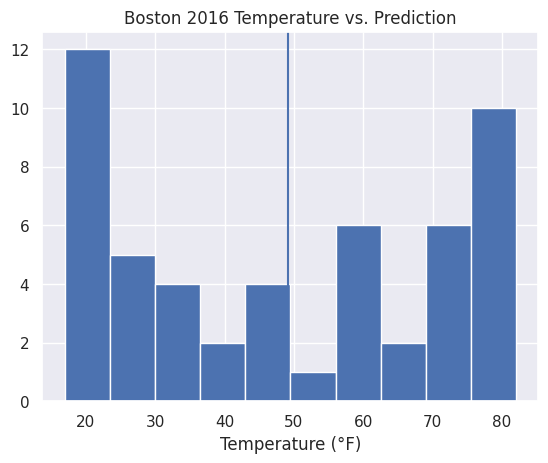

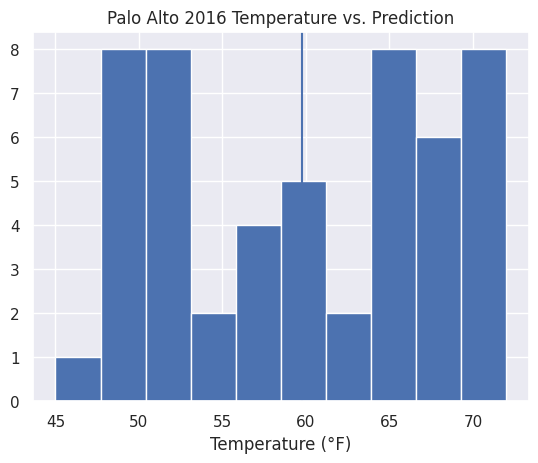

Mean absolute error of prediction in Boston: 20.810650887573964
Mean absolute error of prediction in Palo Alto: 7.208579881656805


In [103]:
b16_df = pd.DataFrame([ 26.,  22.,  20.,  19.,  18.,  19.,  17.,  17.,  19.,  20.,  23., 22.,  28.,  28.,  35.,  38.,  42.,  47.,  49.,  56.,  59.,  61.,
        61.,  70.,  73.,  73.,  73.,  77.,  78.,  82.,  80.,  80.,  81., 78.,  82.,  78.,  76.,  71.,  69.,  66.,  60.,  63.,  56.,  50.,
        44.,  43.,  34.,  33.,  31.,  28.,  27.,  20.],
        columns = ['Weekly Avg Temp'],
        index = pd.date_range('1/1/2015', periods=52, freq='W'))

p16_df = pd.DataFrame([ 50.,  50.,  51.,  48.,  48.,  49.,  50.,  45.,  52.,  50.,  51., 52.,  50.,  56.,  58.,  55.,  61.,  56.,  61.,  62.,  62.,  64.,
        64.,  69.,  71.,  66.,  69.,  70.,  68.,  71.,  70.,  69.,  72., 71.,  66.,  69.,  70.,  70.,  66.,  67.,  64.,  64.,  65.,  61.,
        61.,  59.,  56.,  53.,  55.,  52.,  52.,  51.],
        columns = ['Weekly Avg Temp'],
        index = pd.date_range('1/1/2015', periods=52, freq='W'))

plt.title("Boston 2016 Temperature vs. Prediction")
plt.hist([b16_df['Weekly Avg Temp']], histtype='bar')
plt.axvline(b15_mean)
plt.xlabel('Temperature (°F)')
plt.show()

plt.title("Palo Alto 2016 Temperature vs. Prediction")
plt.hist([p16_df['Weekly Avg Temp']], histtype='bar')
plt.axvline(p15_mean)
plt.xlabel('Temperature (°F)')
plt.show()

b_mae = np.mean(abs(b15_mean - b16_df['Weekly Avg Temp']))
p_mae = np.mean(abs(p15_mean - p16_df['Weekly Avg Temp']))

print("Mean absolute error of prediction in Boston:", b_mae)
print("Mean absolute error of prediction in Palo Alto:", p_mae)